<a href="https://colab.research.google.com/github/aditya-jindal/pepe_is_that_you/blob/main/pepe_is_that_you.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Pepe is that You 😧😩**

#Importing Dependencies

In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Converting Images to expected extensions

In [5]:
data_dir = '/content/drive/MyDrive/pepe_is_that_you'

In [6]:
image_extensions = ['jpeg', 'bmp', 'png', 'gif']

In [7]:
for class_dir in os.listdir(data_dir):
  for image_name in os.listdir(os.path.join(data_dir, class_dir)):
    image_path = os.path.join(data_dir, class_dir, image_name)
    try:
      image = cv2.imread(image_path)
      image_type = imghdr.what(image_path)
      if image_type not in image_extensions:
        converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        os.remove(image_path)
        Image.fromarray(converted_image).save(f'{image_path}.jpeg', 'jpeg')
    except Exception as e:
      print(f"Encountered an exception with {class_dir}/{image_name}: {e}")

#Load the Data

In [8]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 950 files belonging to 2 classes.


In [14]:
data_iterator = data.as_numpy_iterator()

In [13]:
count = sum(1 for _ in data_iterator)

print("Number of batches:", count)

Number of batches: 30


In [10]:
batch = data_iterator.next()

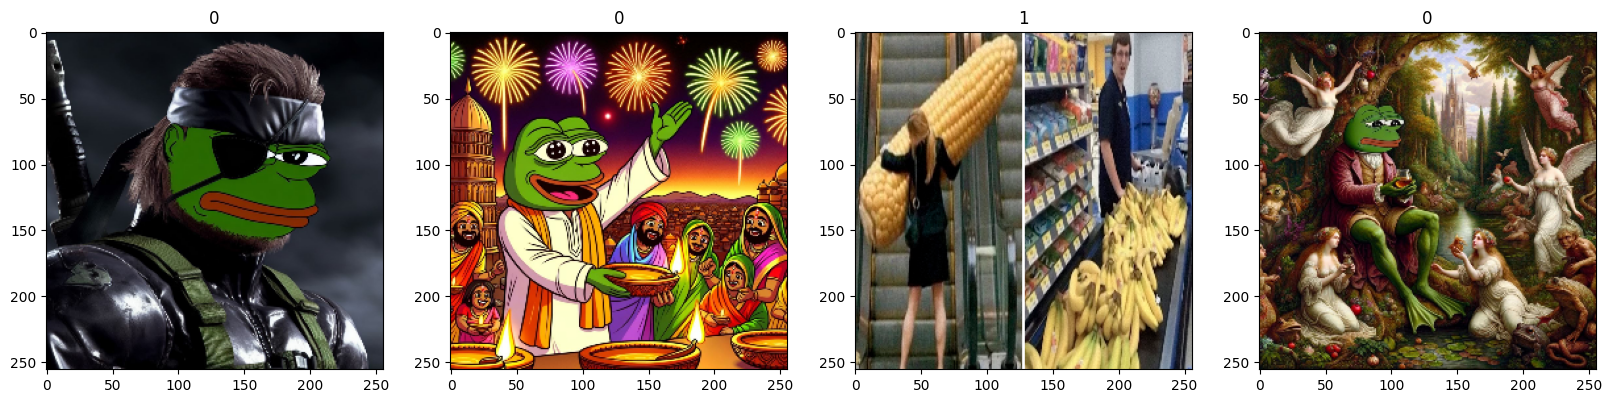

In [41]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

+ 0 - It's Pepe 🐸🎸
+ 1 - It's not Pepe 🐸💢

#Data Preprocessing

In [15]:
data = data.map(lambda x,y: (x/255, y))

##Partition Dataset

In [16]:
len(data)

30

In [17]:
train_size = int(len(data) * .7)
val_size = int(len(data) * .2)
test_size = int(len(data) * .1)

In [18]:
train_size, val_size, test_size

(21, 6, 3)

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size).skip(val_size).take(test_size)

In [20]:
len(train), len(val), len(test)

(21, 6, 3)

#Model Architecture

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [22]:
model = Sequential([
    Input((256,256,3)),
    Conv2D(16, (3,3), 1, activation='relu'),
    MaxPooling2D(),

    Conv2D(32, (3,3), 1, activation='relu'),
    MaxPooling2D(),

    Flatten(),

    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 123008)            0         
                                                                 
 dense (Dense)               (None, 256)               3

In [24]:
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(1e-3), metrics=['accuracy'])

##Train the Model

In [25]:
logdir = '/content/logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
history = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
21/21 [==============================] - 41s 2s/step - loss: 1.3446 - accuracy: 0.7783 - val_loss: 0.2740 - val_accuracy: 0.9167
Epoch 2/20
21/21 [==============================] - 22s 897ms/step - loss: 0.2480 - accuracy: 0.9018 - val_loss: 0.1520 - val_accuracy: 0.9635
Epoch 3/20
21/21 [==============================] - 33s 1s/step - loss: 0.1144 - accuracy: 0.9643 - val_loss: 0.1248 - val_accuracy: 0.9635
Epoch 4/20
21/21 [==============================] - 37s 2s/step - loss: 0.0591 - accuracy: 0.9821 - val_loss: 0.0641 - val_accuracy: 0.9844
Epoch 5/20
21/21 [==============================] - 35s 1s/step - loss: 0.0317 - accuracy: 0.9940 - val_loss: 0.0493 - val_accuracy: 0.9896
Epoch 6/20
21/21 [==============================] - 20s 884ms/step - loss: 0.0293 - accuracy: 0.9896 - val_loss: 0.1983 - val_accuracy: 0.9323
Epoch 7/20
21/21 [==============================] - 24s 942ms/step - loss: 0.0146 - accuracy: 0.9985 - val_loss: 0.0614 - val_accuracy: 0.9896
Epoch 8/20


In [27]:
model.save('/content/pepe_is_that_you_v1.keras')

#Evaluate Model Performance

##Plot Performance

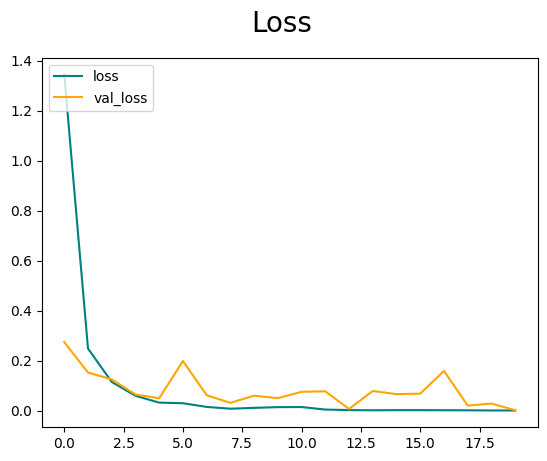

In [28]:
fig = plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()

##Evaluate metrics

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 1s 550ms/step


In [32]:
print("Precision:", pre.result().numpy())
print("Recall:", re.result().numpy())
print("Accuracy:", acc.result().numpy())

Precision: 0.975
Recall: 1.0
Accuracy: 0.9883721


Looks Great!
The model has achieved an accuracy of:
+ 1 on the test set
+ 1 on the val set
+ .988 on the test set

#Testing the model on our images from the internet

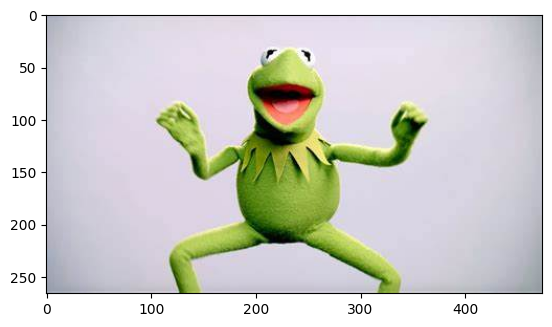

In [59]:
# enter your image name that you've uploaded in the files section on colab
image_name = "pepe wannabe.jpg"

img = cv2.imread(f'/content/{image_name}')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [66]:
processed_image = tf.image.resize(img, (256,256)) / 255
yhat = model.predict(np.expand_dims(processed_image, axis=0), verbose=False)

pepe = True if yhat<0.5 else False

if(pepe):
  print("🐸👋: hey")
else:
  print("🐸💢: that's not me")

🐸💢: that's not me
